<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#四模型回归问题做XGB" data-toc-modified-id="四模型回归问题做XGB-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>四模型回归问题做XGB</a></span></li></ul></div>

## 四模型回归问题做XGB

In [2]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('data_TRAIN07.csv')

In [4]:
label = pd.read_csv('label.csv')

In [5]:
train_all_label =  pd.merge(train,label,on=['day','tx_id']) 

In [6]:
train_all_label

,day,tx_id,best_bid_price_1,best_bid_size_1,best_ask_price_1,best_ask_size_1,best_bid_price_2,best_bid_size_2,best_ask_price_2,best_ask_size_2,...,best_ask_price_2_max-min,pan,pan_vol,maxloss,maxdd,maxprofit,y1,y2,y3,y4
0,0,0,5325.000000,1853.743083,5326.544137,530.131752,5324.000000,747.000000,5327.544137,422.368906,...,5327.544137,0.0,0.0,NaN,NaN,NaN,-4.5,-16.5,4.5,16.5
1,0,1,5324.417706,1100.278874,5325.417706,109.841159,5323.417706,1251.266860,5326.417706,580.461710,...,5326.980921,0.0,0.0,NaN,NaN,NaN,-2.0,-15.0,2.0,15.0
2,0,2,5323.769479,624.261965,5324.769479,678.384012,5322.769479,1433.769518,5325.769479,740.246991,...,5326.577107,0.0,0.0,NaN,NaN,NaN,-2.0,-13.0,2.0,13.0
3,0,3,5321.747952,1347.070253,5323.761989,322.890525,5320.747952,5450.165220,5324.761989,477.552266,...,5326.123328,0.0,0.0,NaN,NaN,NaN,-1.0,-12.5,1.0,12.5
4,0,4,5320.428506,7311.622422,5321.428506,1252.269814,5319.428506,5760.219083,5322.428506,1414.335264,...,5325.384363,0.0,0.0,NaN,NaN,NaN,0.0,-12.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875692,109,8095,5666.000000,303.000000,5667.000000,904.000000,5665.000000,995.000000,5668.000000,1017.000000,...,5666.628270,0.0,0.0,0.000562,0.001762,0.001762,2.0,2.0,-2.0,-2.0
875693,109,8096,5666.000000,303.000000,5667.000000,904.000000,5665.000000,985.000000,5668.000000,1022.500000,...,5666.648270,0.0,0.0,0.000562,0.001762,0.001762,2.0,2.0,-2.0,-2.0
875694,109,8097,5666.000000,302.833333,5667.000000,838.333333,5665.000000,975.000000,5668.000000,1028.000000,...,5666.668270,0.0,0.0,0.000658,0.001762,0.001762,2.0,2.0,-2.0,-2.0
875695,109,8098,5666.000000,297.295455,5667.000000,810.000000,5665.000000,975.000000,5668.000000,1028.000000,...,5666.688270,0.0,0.0,0.000592,0.001762,0.001762,2.0,2.0,-2.0,-2.0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

drop_columns = ['day', 'y1','y2','y3','y4','max_id','classification']  # 删除特征和标签
features = [f for f in train_all_label.columns if f not in drop_columns]  # 最终的特征
train_all = train_all_label[features]
train_label = train_all_label[['y1','y2','y3','y4']]

In [8]:
train_label = train_label.fillna(0)  # 每个action的Nan用0填充

In [9]:
import pickle

In [10]:
# def kfold_xgb_regression(train, x_test, target, index, seed=2021):
#     kf = KFold(n_splits=3, shuffle=True, random_state=seed)
#     params = {
#         'eta': 0.08,  
#         'objective': 'reg:linear',
#         'colsample_bytree': 0.8,
#         'eval_metric':'rmse',
#         'subsample': 0.8,
#         'seed': seed, 
#         'tree_method':'gpu_hist',
#      }
#     y_sub = np.zeros(len(x_test))
#     prob_oof = np.zeros(train.shape[0])
#     feature_importance_df = pd.DataFrame()  # 存储特征重要性
#     for fold, (train_index, val_index) in tqdm(enumerate(kf.split(train, target))):
#         X_train, X_val = train.iloc[train_index], train.iloc[val_index]
#         y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#         data_train =  xgb.DMatrix(X_train, y_train)
#         data_val =  xgb.DMatrix(X_val, y_val)
#         watchlist = [(data_train,'train'),(data_val,'val')]
#         n_round = 2500
#         model = xgb.train(dict(params),data_train,num_boost_round = n_round,evals = watchlist,
#                                  early_stopping_rounds=100)
        
#         pickle.dump(model, open(f"xgb_regression_{fold}_{index}_100+feature3.pkl", "wb"))
#         prob_oof[val_index] = model.predict(xgb.DMatrix(train.iloc[val_index]))
        
#         # 预测和验证
#         data_test = xgb.DMatrix(x_test)
#         y_sub = y_sub + model.predict(data_test) / kf.n_splits  # 预测最后提交的结果，输出概率值
        
#         # 特征重要性
#         fold_importance_df = pd.DataFrame()
#         fold_importance_df["feature"] = model.get_score().keys()
#         fold_importance_df["importance"] = model.get_score().values()  # 默认为weight
# #         fold_importance_df["importance"] = model.get_score(importance_type = 'gain').values()  # 重要性选择为gain
#         fold_importance_df["fold"] = fold + 1
#         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
                            
#     return y_sub, prob_oof,feature_importance_df

In [12]:
train_all

,tx_id,best_bid_price_1,best_bid_size_1,best_ask_price_1,best_ask_size_1,best_bid_price_2,best_bid_size_2,best_ask_price_2,best_ask_size_2,best_bid_price_3,...,rise_ask,best_bid_price_1_max-min,best_bid_price_2_max-min,best_ask_price_1_max-min,best_ask_price_2_max-min,pan,pan_vol,maxloss,maxdd,maxprofit
0,0,5325.000000,1853.743083,5326.544137,530.131752,5324.000000,747.000000,5327.544137,422.368906,5323.000000,...,0.000000,5325.000000,5324.000000,5326.544137,5327.544137,0.0,0.0,NaN,NaN,NaN
1,1,5324.417706,1100.278874,5325.417706,109.841159,5323.417706,1251.266860,5326.417706,580.461710,5322.417706,...,-0.010935,5324.708853,5323.708853,5325.980921,5326.980921,0.0,0.0,NaN,NaN,NaN
2,2,5323.769479,624.261965,5324.769479,678.384012,5322.769479,1433.769518,5325.769479,740.246991,5321.769479,...,-0.023108,5324.395728,5323.395728,5325.577107,5326.577107,0.0,0.0,NaN,NaN,NaN
3,3,5321.747952,1347.070253,5323.761989,322.890525,5320.747952,5450.165220,5324.761989,477.552266,5319.747952,...,-0.061071,5323.733784,5322.733784,5325.123328,5326.123328,0.0,0.0,NaN,NaN,NaN
4,4,5320.428506,7311.622422,5321.428506,1252.269814,5319.428506,5760.219083,5322.428506,1414.335264,5318.428506,...,-0.085850,5323.072729,5322.072729,5324.384363,5325.384363,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875692,8095,5666.000000,303.000000,5667.000000,904.000000,5665.000000,995.000000,5668.000000,1017.000000,5664.000000,...,-0.351740,5664.603806,5663.603806,5665.628270,5666.628270,0.0,0.0,0.000562,0.001762,0.001762
875693,8096,5666.000000,303.000000,5667.000000,904.000000,5665.000000,985.000000,5668.000000,1022.500000,5664.000000,...,-0.351740,5664.623806,5663.623806,5665.648270,5666.648270,0.0,0.0,0.000562,0.001762,0.001762
875694,8097,5666.000000,302.833333,5667.000000,838.333333,5665.000000,975.000000,5668.000000,1028.000000,5664.000000,...,-0.351740,5664.643806,5663.643806,5665.668270,5666.668270,0.0,0.0,0.000658,0.001762,0.001762
875695,8098,5666.000000,297.295455,5667.000000,810.000000,5665.000000,975.000000,5668.000000,1028.000000,5664.000000,...,-0.351740,5664.663806,5663.663806,5665.688270,5666.688270,0.0,0.0,0.000592,0.001762,0.001762


In [22]:
# new_73_fea = ['tx_id', 'rise_ask', 'maxdd', 'maxloss', 'spread80', 'qty80',
#        'qty_ma80', 'deapth80', 'best_bid_size_5', 'best_ask_size_5',
#        'bid_size3_ma80', 'best_bid_size_380', 'best_ask_size_380',
#        'best_bid_size_4', 'best_ask_size_180', 'ask_size3_ma80',
#        'bid_size2_ma80', 'spread55', 'best_ask_size_4', 'best_bid_size_180',
#        'qty55', 'spread30', 'best_bid_size_280', 'bid_size1_ma80',
#        'best_ask_size_280', 'ask_size1_ma80', 'ask_size2_ma80', 'qty_ma55',
#        'best_bid_price_1', 'deapth55', 'qty30', 'bid_size3_ma55',
#        'best_bid_size_355', 'bid_size3_ma30', 'ask_size3_ma55',
#        'best_ask_size_3', 'best_ask_size_355', 'ask_size3_ma30',
#        'best_bid_size_3', 'bid_size2_ma55', 'bid_size1_ma55',
#        'best_ask_size_330', 'best_ask_size_155', 'ask_size1_ma55',
#        'best_bid_size_255', 'best_bid_size_155', 'ask_size2_ma55',
#        'best_bid_size_330', 'best_ask_size_255', 'best_bid_size_2', 'deapth30',
#        'bid_size2_ma30', 'best_ask_size_230', 'qty_ma30', 'best_bid_size_230',
#        'bid_size1_ma30', 'best_ask_size_2', 'last_price80', 'ask_size1_ma30',
#        'ask_size2_ma30', 'best_bid_size_130', 'best_ask_size_130',
#        'best_bid_size_1', 'last_price55', 'last_price30', 'bid_size3_ma5',
#        'best_ask_size_1', 'ask_size3_ma5', 'maxprofit', 'deapth',
#        'ask_size2_ma5', 'bid_size2_ma5', 'best_bid_price_1_max-min']

new_32_fea = ['tx_id', 'rise_ask', 'maxdd', 'maxloss', 'spread80', 'qty80',
       'qty_ma80', 'deapth80', 'best_bid_size_5', 'best_ask_size_5',
       'bid_size3_ma80', 'best_bid_size_380', 'best_ask_size_380',
       'best_bid_size_4', 'best_ask_size_180', 'ask_size3_ma80',
       'bid_size2_ma80', 'spread55', 'best_ask_size_4', 'best_bid_size_180',
       'qty55', 'spread30', 'best_bid_size_280', 'bid_size1_ma80',
       'best_ask_size_280', 'ask_size1_ma80', 'ask_size2_ma80', 'qty_ma55',
       'best_bid_price_1', 'deapth55', 'qty30', 'bid_size3_ma55']
train_all = train_all[new_32_fea]
train_all

,tx_id,rise_ask,maxdd,maxloss,spread80,qty80,qty_ma80,deapth80,best_bid_size_5,best_ask_size_5,...,best_bid_size_280,bid_size1_ma80,best_ask_size_280,ask_size1_ma80,ask_size2_ma80,qty_ma55,best_bid_price_1,deapth55,qty30,bid_size3_ma55
0,0,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,3042.000000,502.849802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5325.000000,0.000000,0.000000,0.000000
1,1,-0.010935,NaN,NaN,0.000000,0.000000,0.000000,0.000000,8353.688565,638.195448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5324.417706,0.000000,0.000000,0.000000
2,2,-0.023108,NaN,NaN,0.000000,0.000000,0.000000,0.000000,3389.724270,622.230450,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5323.769479,0.000000,0.000000,0.000000
3,3,-0.061071,NaN,NaN,0.000000,0.000000,0.000000,0.000000,3317.693424,379.429227,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5321.747952,0.000000,0.000000,0.000000
4,4,-0.085850,NaN,NaN,0.000000,0.000000,0.000000,0.000000,591.698138,485.069753,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5320.428506,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875692,8095,-0.351740,0.001762,0.000562,0.145049,129.421005,25.072398,0.182080,2094.000000,299.000000,...,176.211568,578.689790,449.885773,494.350284,1182.099844,34.208109,5666.000000,0.160049,207.830840,1617.117631
875693,8096,-0.351740,0.001762,0.000562,0.144625,129.437768,24.970012,0.176577,2094.000000,299.000000,...,170.333555,578.177776,445.851907,498.612784,1173.206094,34.208109,5666.000000,0.157315,207.830840,1595.535813
875694,8097,-0.351740,0.001762,0.000658,0.144625,129.465082,25.620013,0.176823,2094.000000,299.000000,...,170.813519,575.042520,444.659752,507.675123,1175.432920,35.238412,5666.000000,0.154437,207.791840,1573.953995
875695,8098,-0.351740,0.001762,0.000592,0.144625,129.441870,25.770960,0.176368,2094.000000,299.000000,...,171.795052,570.421213,441.899142,517.737623,1179.370420,35.444335,5666.000000,0.151354,207.709270,1552.372176


In [23]:
train_label

,y1,y2,y3,y4
0,-4.5,-16.5,4.5,16.5
1,-2.0,-15.0,2.0,15.0
2,-2.0,-13.0,2.0,13.0
3,-1.0,-12.5,1.0,12.5
4,0.0,-12.0,0.0,12.0
...,...,...,...,...
875692,2.0,2.0,-2.0,-2.0
875693,2.0,2.0,-2.0,-2.0
875694,2.0,2.0,-2.0,-2.0
875695,2.0,2.0,-2.0,-2.0


In [24]:
def kfold_xgb_regression_single_notest(train, target, index, seed=2021):
    X_tr,X_val,y_tr,y_val = train_test_split(train,target,test_size = 0.1,random_state = seed)
    params = {
        'eta': 0.23,  
        'objective': 'reg:linear',
        'colsample_bytree': 0.8,
        'eval_metric':'rmse',
        'subsample': 0.7,
        'seed': seed, 
        'tree_method':'gpu_hist',
     }

    feature_importance_df = pd.DataFrame()  # 存储特征重要性
    data_train =  xgb.DMatrix(X_tr, y_tr)
    data_val =  xgb.DMatrix(X_val, y_val)
    watchlist = [(data_train,'train'),(data_val,'val')]
    n_round = 2500
    model = xgb.train(dict(params),data_train,num_boost_round = n_round,evals = watchlist,
                             early_stopping_rounds=100)

    pickle.dump(model, open(f"xgb_regression_{index}_32feature_lr2_sub_all.pkl", "wb"))
    

    # 特征重要性
    feature_importance_df["feature"] = model.get_score().keys()
    feature_importance_df["importance"] = model.get_score().values()  # 默认为weight
#         fold_importance_df["importance"] = model.get_score(importance_type = 'gain').values()  # 重要性选择为gain
   
                            
    return feature_importance_df

In [25]:

seeds = [2022]
for seed in seeds:
    for i in range(4):
        feature_importance = kfold_xgb_regression_single_notest(train_all, train_label.iloc[:,i], i, seed)
#         y_sub, y_train_hat,feature_importance = kfold_xgb_regression(X_train, X_test, y_train.iloc[:,i], i, seed)
#         y_sub, y_train_hat,feature_importance = kfold_lgb_regression(train_all, x_test, train_label.iloc[:,i], seed)
#         y_sub_all[:, i] = y_sub
        if (i == 0):
            feature_importance_0 = feature_importance
        if (i == 1):
            feature_importance_1 = feature_importance
        if (i == 2):
            feature_importance_2 = feature_importance
        if (i == 3):
            feature_importance_3 = feature_importance
#     y_sub += y_sub / len(seeds)
#     y_train_hat += y_train_hat / len(seeds)

[20:51:25] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.27825	val-rmse:2.29112
[1]	train-rmse:2.25421	val-rmse:2.26811
[2]	train-rmse:2.23342	val-rmse:2.24767
[3]	train-rmse:2.21904	val-rmse:2.23354
[4]	train-rmse:2.20657	val-rmse:2.22135
[5]	train-rmse:2.19647	val-rmse:2.21092
[6]	train-rmse:2.18574	val-rmse:2.20026
[7]	train-rmse:2.17813	val-rmse:2.19240
[8]	train-rmse:2.16995	val-rmse:2.18430
[9]	train-rmse:2.16073	val-rmse:2.17460
[10]	train-rmse:2.15794	val-rmse:2.17242
[11]	train-rmse:2.15159	val-rmse:2.16676
[12]	train-rmse:2.14549	val-rmse:2.16139
[13]	train-rmse:2.14020	val-rmse:2.15471
[14]	train-rmse:2.13264	val-rmse:2.14636
[15]	train-rmse:2.12907	val-rmse:2.14242
[16]	train-rmse:2.12375	val-rmse:2.13725
[17]	train-rmse:2.11601	val-rmse:2.12997
[18]	train-rmse:2.11206	val-rmse:2.12721
[19]	train-rmse:2.10637	val-rmse:2.12127
[20]	train-rmse:2.09995	val-rmse:2.11519
[21]	train-rmse:2.09720	val-rm

In [41]:
y_sub_all

array([[-6.9593153 , -3.33096385,  8.9811554 ,  4.62697935],
       [-0.82468057, -0.6808421 ,  0.50285757, -1.05665171],
       [-2.37766457, -0.93316704,  2.4601028 ,  0.36051631],
       ...,
       [ 1.22945416,  2.88688731, -1.185323  , -2.81391549],
       [-0.60319054, -3.42241216,  1.13470876,  2.47026277],
       [ 0.55697596,  0.97346008, -0.4022046 , -1.28617823]])

In [42]:
np.size(y_sub_all)

700560

In [43]:
result = np.argmax(y_sub_all, axis=1)
result

array([2, 2, 2, ..., 1, 3, 1])

In [19]:
y_test = y_test.values

In [44]:
y_true = np.argmax(y_test, axis=1)

In [45]:
y_true

array([2, 0, 2, ..., 1, 3, 1])

In [46]:
accuracy_score(result,y_true)

0.6884035628639945

In [23]:
feature_importance_0

,feature,importance
0,best_bid_size_1,1115
1,best_ask_price_25,296
2,ask1_ma_std80,54
3,qty_ma55,1708
4,tx_id,5592
...,...,...
209,best_ask_price_3,29
210,best_bid_price_3,28
211,bid3_ma5,13
212,best_bid_price_5,4


In [25]:
feature_importance_0.to_csv('feature_importance_0.csv',index=False)
feature_importance_1.to_csv('feature_importance_1.csv',index=False)
feature_importance_2.to_csv('feature_importance_2.csv',index=False)
feature_importance_3.to_csv('feature_importance_3.csv',index=False)

In [26]:
# ## plot feature importance
# N = 158 # TOP N的特征
# cols = (feature_importance_0[["feature", "importance"]] .groupby("feature").mean().sort_values(by="importance", ascending=False)[:N].index)
# best_features = feature_importance_0.loc[feature_importance_0.feature.isin(cols)].sort_values(by='importance',ascending=False)
# best_features  # 每个fold前Top N的特征，并按importance从大到小排序

In [27]:
# best_features.to_csv('best_features.csv',index=False)

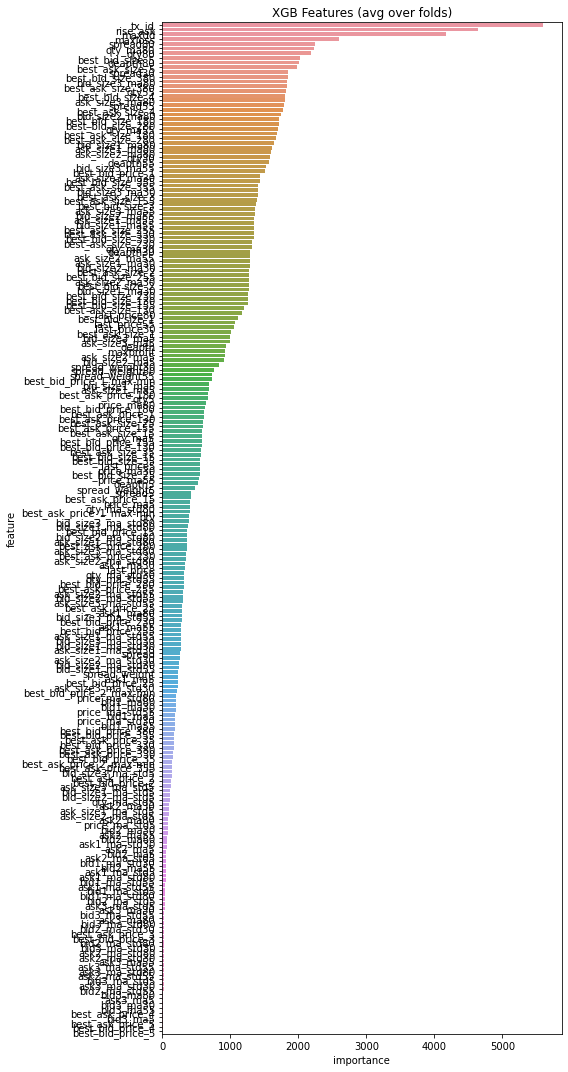

In [28]:
plt.figure(figsize=(8, 15))
sns.barplot(y="feature", x="importance",data=feature_importance_0.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout()
plt.savefig('xgb_importances_weight_214fea_single_y1.png')
plt.show()

In [ ]:
def lgb(train_x, train_y, test_x,seed):

    train_x = train_x.values
    test_x = test_x.values
    the_folds = 10
    seed = seed
    kf_nums = KFold(n_splits=the_folds, shuffle=True, random_state=seed)
    train = np.zeros((train_x.shape[0]))
    test = np.zeros((test_x.shape[0]))
    my_test_pred = np.zeros((the_folds, test_x.shape[0]))
    the_all_pred = np.zeros((the_folds, test_x.shape[0]))
    cv_scores = []
    cv_iteration = []

    for i, (train_index, test_index) in enumerate(kf_nums.split(train_x, train_y)):
        the_train = lightgbm.Dataset(train_x[train_index], label=train_y[train_index])
        the_test = lightgbm.Dataset(train_x[test_index], label=train_y[test_index])
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metrics':'mean_squared_error',
            'max_depth':8,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'learning_rate': 0.05,
            'seed': 0,
            'nthread': 8,
            'verbose': -1,
        }
        num_round = 2000
        early_stopping_rounds = 200
        if the_test:
            model = lightgbm.train(params, the_train, num_round, valid_sets=the_test, verbose_eval=200,early_stopping_rounds=early_stopping_rounds)
            val_pred = model.predict(train_x[test_index], num_iteration=model.best_iteration)#
            pred = model.predict(test_x, num_iteration=model.best_iteration)#
            train[test_index] = val_pred
            my_test_pred[i, :] = pred
            cv_scores.append(mean_squared_error (train_y[test_index], val_pred))
            cv_iteration.append(model.best_iteration)
            the_all_pred[i, :] = pred
        
        print("cv_score is:", cv_scores)

    test[:] = my_test_pred.mean(axis=0)

    print("val_mean:" , np.mean(cv_scores))
    print("val_std:", np.std(cv_scores))
    return train, test

In [ ]:
train, test, test_pre_all, cv_scores,importance_list= lgb_cv(train_x, train_y, test_x)